# Bloom Classifier: A Flower Species Recognition System

## Exploratory Data Analysis and Model Selection

In this notebook, our primary goal is to develop an image classification model capable of identifying various types of flowers. To achieve this, we will begin by loading and exploring the flower dataset to gain valuable insights into the available information. Additionally, we will experiment with different machine learning models, leveraging a small subset of data points to evaluate their initial performance. Through this preliminary data analysis and model selection process, we aim to lay a solid foundation for building a robust and accurate Bloom Classifier. 

### Loading and reading the dataset

We start with a script to download and load the data, and perform a preliminary exploration. For now, we'll simply count the number of images in each category.

In [3]:
import os
import urllib.request
import tarfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split 

# Download the data
data_url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
data_file = "./data/102flowers.tgz"
os.makedirs(os.path.dirname(data_file), exist_ok=True)
urllib.request.urlretrieve(data_url, data_file)


('./data/102flowers.tgz', <http.client.HTTPMessage at 0x1371cf0a0>)

Note: we could also get the data from torchvision.datasets.Flowers102: https://pytorch.org/vision/main/generated/torchvision.datasets.Flowers102.html 

Next step after downloading a compressed dataset is to extract it so we can access its contents:

In [4]:
# Extract the data
with tarfile.open(data_file) as tar:
    tar.extractall(path='./data')

We use cv2.imread() function from OpenCV (cv2). This function reads the image file and returns a NumPy array representing the image.     
The cv2.imread() function reads an image from a file and converts it into an array format that can be handled by OpenCV. This array format is essentially a 3D NumPy array.

The output of cv2.imread() is a NumPy array representing the image. The shape of this array is (height, width, channels), where the number of channels is 3 for a color image (representing Red, Green, and Blue channels respectively) and 1 for a grayscale image. Each value in this array is an 8-bit integer (0-255) representing pixel intensity.


All the images are stored as elements in the images list:

In [5]:
# Load the data
image_folder = './data/jpg/'
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]
images = [cv2.imread(file) for file in image_files]


In [25]:
type(images[0])
print(images[0].shape)
# Check the shape and type of the first image
print(images[0].shape, images[0].dtype)



(752, 500, 3)
(752, 500, 3) uint8


image_files contains a list of complete file paths for all the images in the folder. Let's see how many images the dataset contains:

In [6]:
# Print the total number of images
print(f'Total number of images: {len(images)}')

Total number of images: 8189


Now, we load the labels of the images:

In [7]:
# Load the labels
labels_url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
labels_file = "./data/imagelabels.mat"
urllib.request.urlretrieve(labels_url, labels_file)

('./data/imagelabels.mat', <http.client.HTTPMessage at 0x1374b3fd0>)

After loading the labels from the URL and saving them locally in ./data/imagelabels.mat, we examine the label data to find out the range of labels:

In [8]:
import scipy.io

# Load the labels from the saved file
labels_data = scipy.io.loadmat(labels_file)
labels = labels_data['labels'][0]

# Find the range of labels
min_label = min(labels)
max_label = max(labels)

print("Minimum Label Value:", min_label)
print("Maximum Label Value:", max_label)
print("Number of Unique Labels:", len(np.unique(labels)))


Minimum Label Value: 1
Maximum Label Value: 102
Number of Unique Labels: 102


In [9]:
print(type(labels))
print(type(labels_data))
print(labels_data.keys())
print(type(labels_data['labels']))

<class 'numpy.ndarray'>
<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'labels'])
<class 'numpy.ndarray'>


Note: The .mat file is a file format used to store data in MATLAB (Matrix Laboratory). To work with .mat files in Python, we use libraries like scipy.io to load and read the data stored in these files. These libraries provide functions to handle MATLAB files and extract the data into Python data structures, enabling interoperability between MATLAB and Python for data analysis and processing tasks.

### Distribution and balance of the dataset

Counting the number of images in each category is important for understanding the distribution and balance of the dataset. In this project each category corresponds to a different type of flower. The dataset should ideally have a relatively balanced distribution of images across all flower categories to avoid bias towards any specific class. An imbalanced dataset may lead to biased model performance, where the classifier might become more proficient at recognizing overrepresented classes while struggling with minority classes. By counting the number of images in each category, we can identify any class imbalances and take appropriate steps to address them, such as data augmentation, resampling, or using specialized techniques for handling imbalanced datasets during model training.

Let's see how manu images each category contains:

In [10]:
from scipy.io import loadmat
labels = loadmat(labels_file)['labels'][0] - 1  # Adjusting labels to be in the range 0-101

# Count the number of images in each category
unique, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(unique, counts))

# Print the number of images in each category
print(f'Number of images in each category: {label_counts}')


Number of images in each category: {0: 40, 1: 60, 2: 40, 3: 56, 4: 65, 5: 45, 6: 40, 7: 85, 8: 46, 9: 45, 10: 87, 11: 87, 12: 49, 13: 48, 14: 49, 15: 41, 16: 85, 17: 82, 18: 49, 19: 56, 20: 40, 21: 59, 22: 91, 23: 42, 24: 41, 25: 41, 26: 40, 27: 66, 28: 78, 29: 85, 30: 52, 31: 45, 32: 46, 33: 40, 34: 43, 35: 75, 36: 108, 37: 56, 38: 41, 39: 67, 40: 127, 41: 59, 42: 130, 43: 93, 44: 40, 45: 196, 46: 67, 47: 71, 48: 49, 49: 92, 50: 258, 51: 85, 52: 93, 53: 61, 54: 71, 55: 109, 56: 67, 57: 114, 58: 67, 59: 109, 60: 50, 61: 55, 62: 54, 63: 52, 64: 102, 65: 61, 66: 42, 67: 54, 68: 54, 69: 62, 70: 78, 71: 96, 72: 194, 73: 171, 74: 120, 75: 107, 76: 251, 77: 137, 78: 41, 79: 105, 80: 166, 81: 112, 82: 131, 83: 86, 84: 63, 85: 58, 86: 63, 87: 154, 88: 184, 89: 82, 90: 76, 91: 66, 92: 46, 93: 162, 94: 128, 95: 91, 96: 66, 97: 82, 98: 63, 99: 49, 100: 58, 101: 48}


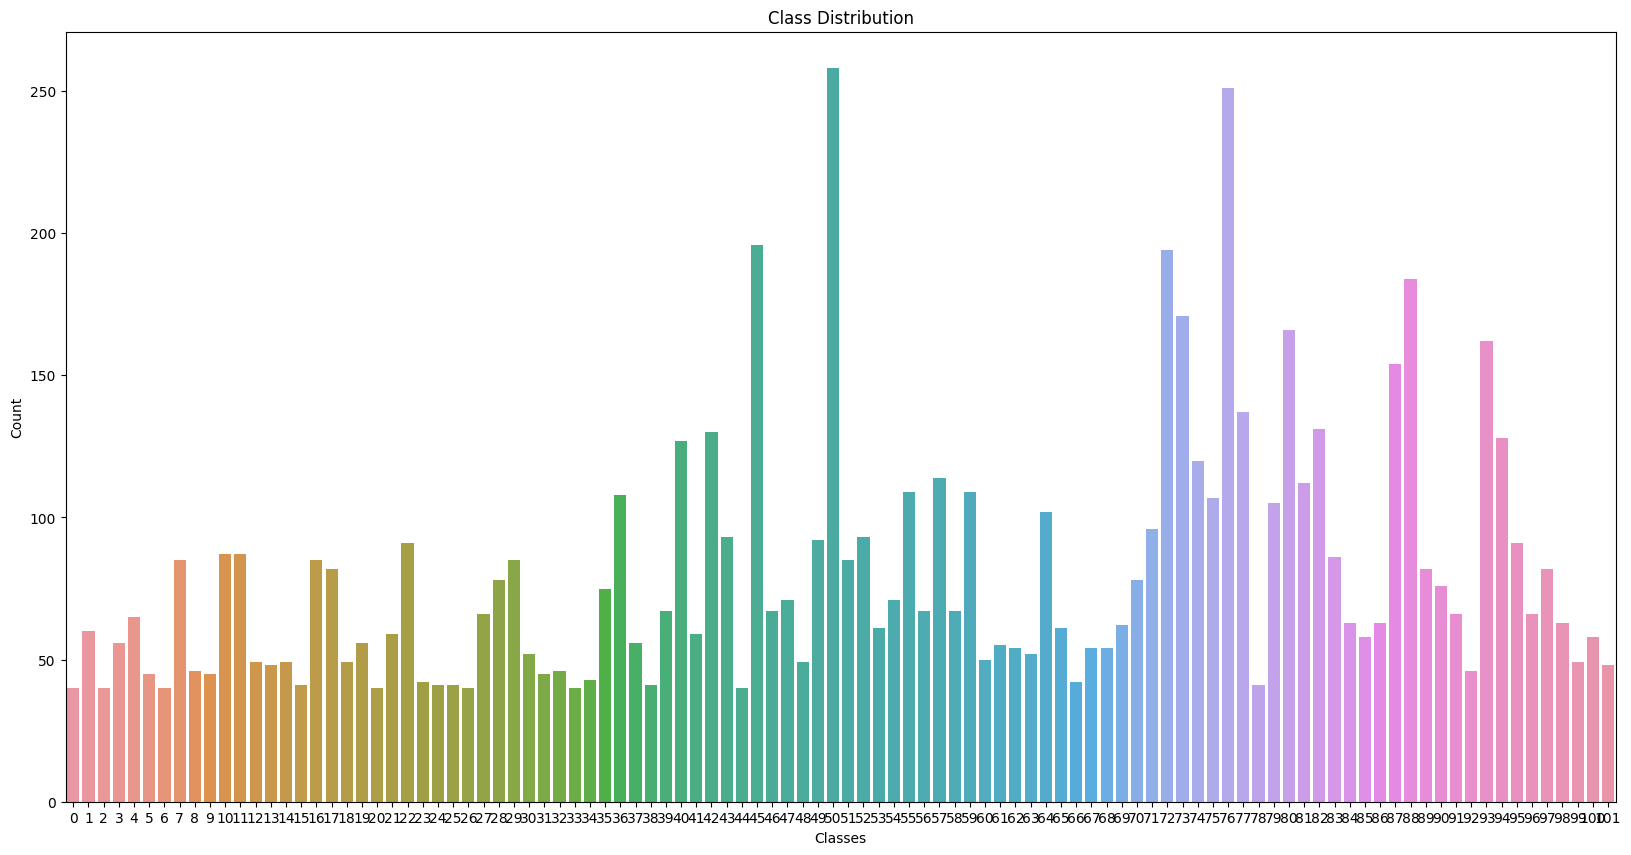

In [11]:
# Check for class imbalance

import seaborn as sns

plt.figure(figsize=(20, 10))
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

**Attention**: we notice **Class Imbalance** in our dataset.      

We can see that the number of images in each category varies significantly. Some classes have a large number of images (e.g., Class 50 with 258 images) while others have relatively few (e.g., Classes 0, 2, 6 with only 40 images each). This indicates a class imbalance in the dataset. We take a note of this and will address it in next steps of the project.

Let's have a look into our datasets and visialize some of the images:

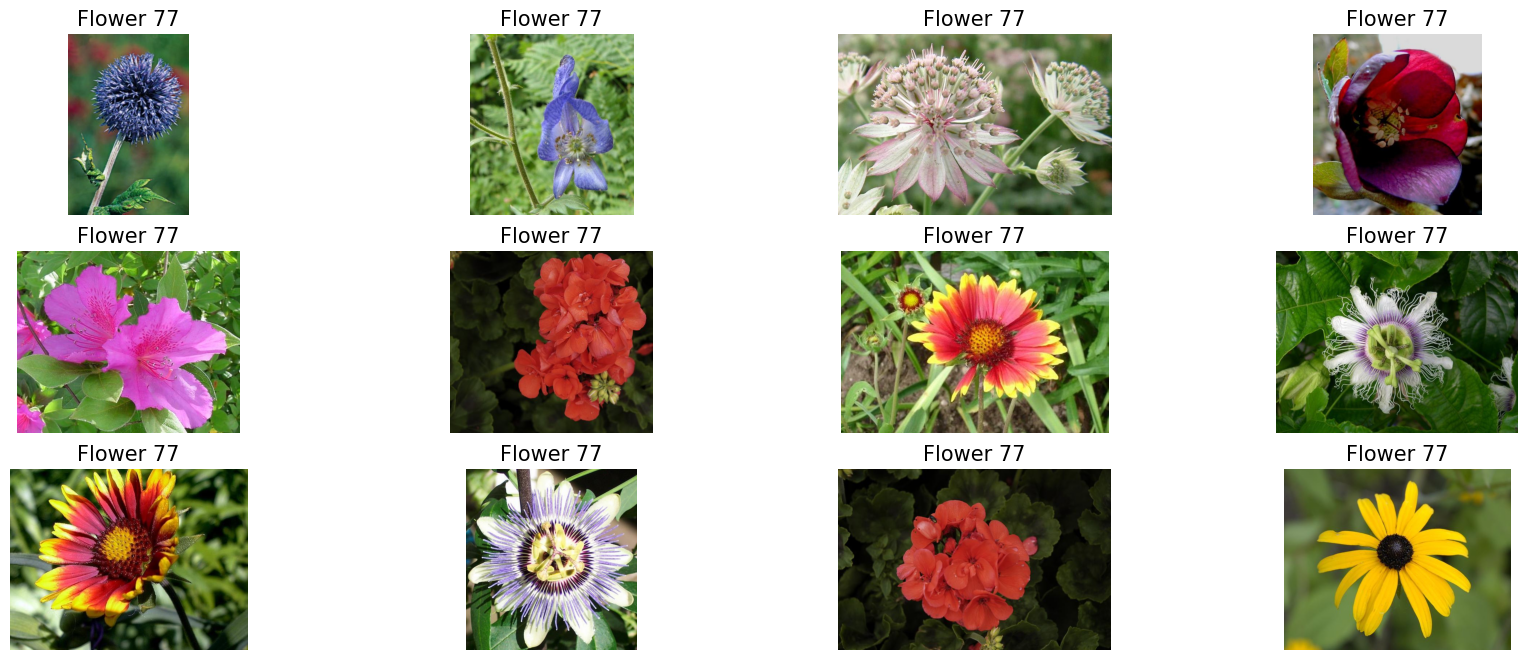

In [13]:
# Visualize some samples
fig, axs = plt.subplots(3,4, figsize=(20, 8))  # Adjust this to show as many images as you need
axs = axs.ravel()

for i in np.arange(0, 12):  # Adjust this to show as many images as you need
    axs[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axs[i].set_title(f'Flower {labels[i]+1}', fontsize=15)  # Label is +1 because we previously subtracted 1
    axs[i].axis('off')

plt.subplots_adjust(wspace=0.5)


### Image sizes

Analyzing the distribution of image sizes is crucial for understanding the variability in image dimensions across the dataset. Examining image sizes can influence various aspects of your image classification pipeline:

**1. Data Exploration and Understanding:**
   Visualizing the distribution of image sizes helps you understand the range of image dimensions in the dataset. You can identify if the images have consistent sizes or if there is a wide variation in image resolutions.

**2. Data Preprocessing Strategies:**
   Understanding image sizes is essential for preprocessing strategies like resizing or cropping. If the images have different sizes, you may need to standardize them to a common resolution before feeding them into the model.

**3. Memory and Processing Considerations:**
   Large images can consume more memory during training and inference. Knowing the distribution of image sizes can help you decide on appropriate batch sizes and optimize memory usage during model training.

**4. Model Input Shape:**
   The distribution of image sizes will influence the input shape of the model. You may need to choose a model architecture that can handle variable input sizes or resize/crop the images to fit the model's input requirements.

**Interpreting the Result Figure:**

The result figure displays the distribution of image heights and widths using histograms. Each histogram shows the count of images for different height or width bins.

**Interpretation:**
- Peak and Spread: Peaks in the histogram indicate the most common image height or width, while the spread of the histogram shows the range of sizes present in the dataset.
- Consistent Sizes: A narrow histogram suggests that most images have similar sizes, indicating consistency in image dimensions.
- Variable Sizes: A broader histogram indicates a wide variation in image sizes, which may require resizing or cropping to create a consistent input size for the model.
- Extreme Sizes: Outliers in the histogram (far from the central cluster) represent images with extreme dimensions that may require special handling.

By analyzing the distribution of image sizes, you can make informed decisions about data preprocessing, image resizing, and model architecture selection. For example, if there is significant variation in image sizes, you might consider resizing all images to a common size (e.g., 224x224) before training the model. Additionally, you can explore different techniques for handling images with extreme dimensions, such as padding or cropping.

As with the color distribution analysis, it's essential to examine multiple images and histograms to gain a more comprehensive understanding of the dataset's image size characteristics. This will help you develop a more robust Bloom Classifier that can handle different image resolutions effectively.

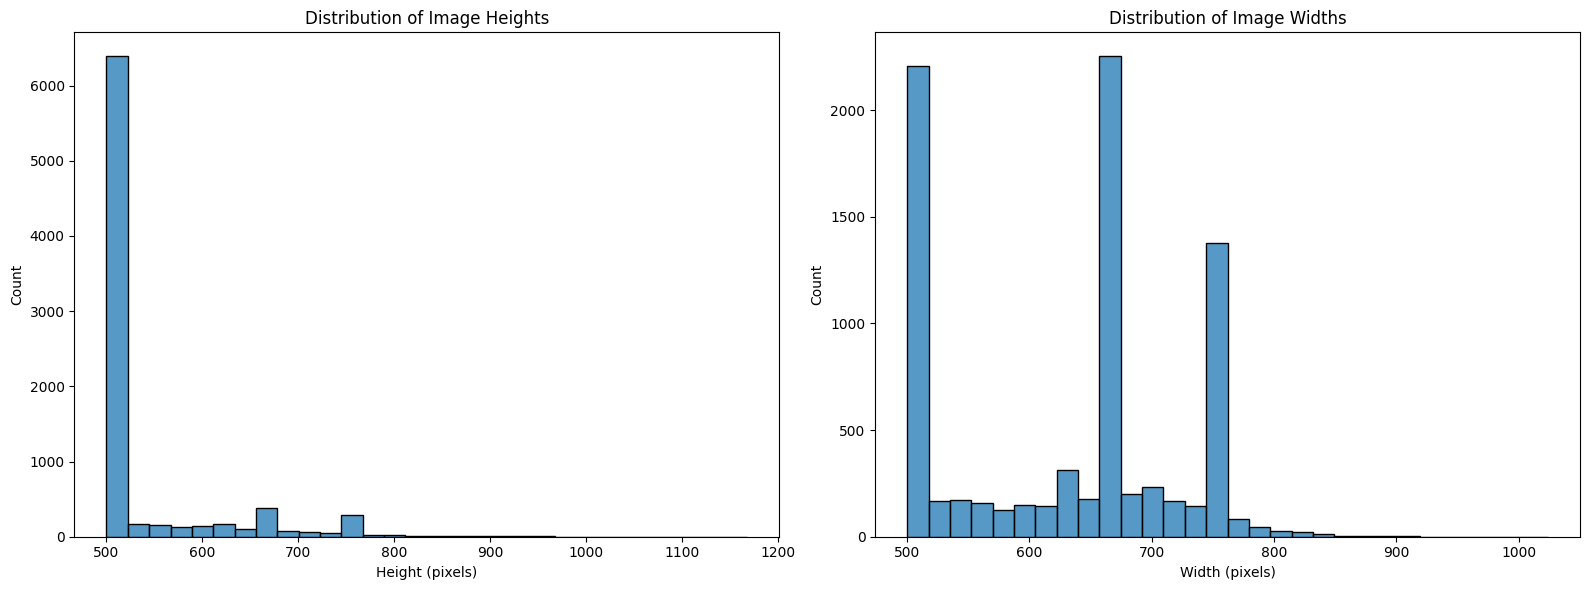

In [14]:
# Check image sizes
heights = [img.shape[0] for img in images]
widths = [img.shape[1] for img in images]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(heights, bins=30)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(widths, bins=30)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


### Color distributions

Analyzing the color distribution of images is an essential task because it provides valuable insights into the **visual characteristics and patterns of the dataset**. Understanding the color distribution can impact various aspects of the machine learning model and image classification pipeline:

**1. Data Exploration and Understanding:**
   Visualizing the color distribution helps you gain a better understanding of how colors are distributed among the images. It allows you to identify whether the dataset has a dominant color palette or if there are variations in colors across different flower categories.

**2. Feature Representation:**
   Color information is an important feature for image classification. Different flower species may have distinct color patterns, and capturing these patterns in the feature representation can help the classifier distinguish between various classes more effectively.

**3. Preprocessing Strategies:**
   The color distribution can influence the preprocessing strategies you apply to the images. For example, if there is significant variation in lighting conditions across the dataset, color normalization techniques might be useful to standardize color values.

**4. Model Selection:**
   The color distribution can guide the choice of image representation and model architecture. For instance, if the color distribution is essential for classification, you may opt for a model that can explicitly capture color information, such as a CNN with multiple input channels.

**5. Addressing Class Imbalance:**
   Analyzing the color distribution can also provide insights into potential class imbalances. If certain flower categories have distinctive color patterns but are underrepresented in the dataset, this can inform your data augmentation or resampling strategies to address class imbalance effectively.

**Interpreting the Result Figure:**

The result figure displays the color distribution of a randomly selected image from the dataset. The x-axis represents the pixel value of colors ranging from 0 to 255, while the y-axis represents the count of pixels at each color value. The three colored lines (red, green, and blue) represent the color channels (RGB) and show how pixel counts vary for each channel.

**Interpretation:**
- Peaks and Valleys: Peaks in the histogram indicate dominant color values, while valleys represent areas with fewer pixels of that specific color.
- Color Balance: If the three color channels have similar peak intensities, it suggests that the image has a balanced color distribution, and each channel contributes almost equally to the overall appearance.
- Color Dominance: A dominant color channel with a sharp peak indicates that the image is predominantly composed of that color.
- Color Variation: If the histogram shows a broader distribution across all color channels, it suggests that the image has more diverse colors and less dominance of a specific color.


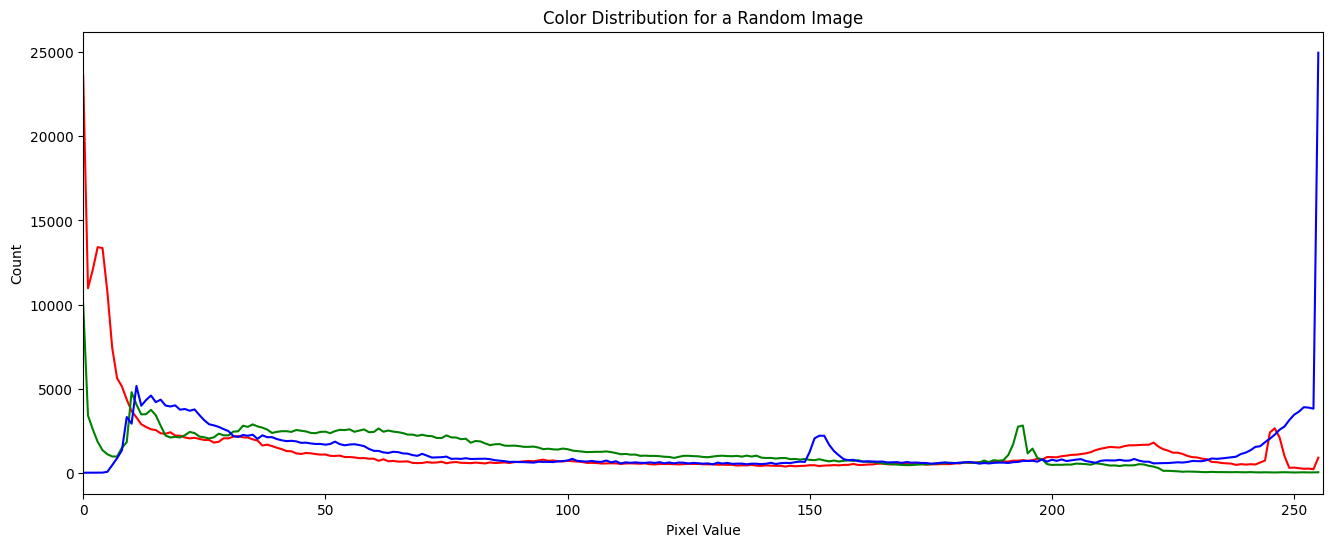

In [16]:
# Choose a random index for the image
random_index = np.random.choice(len(images))

# Retrieve the image using the randomly chosen index
random_image = images[random_index]

plt.figure(figsize=(16, 6))
colors = ('r', 'g', 'b')
for i, color in enumerate(colors):
    histogram = cv2.calcHist([random_image], [i], None, [256], [0, 256])
    plt.plot(histogram, color=color)
    plt.xlim([0, 256])

plt.title('Color Distribution for a Random Image')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.show()


Here, we create a custom dataset to use it moving forward:

In [26]:
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchsummary
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

# data directories

image_folder = './data/jpg/'
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]

labels_file = "./data/imagelabels.mat"
labels_data = scipy.io.loadmat(labels_file)
labels = labels_data['labels'][0] - 1  # Adjusting labels to be in the range 0-101

class FlowerDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])  # Open image file
        image = image.convert('RGB')  # Convert image to RGB channels
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [27]:
# Create an instance of the custom dataset
flower_dataset = FlowerDataset(image_files, labels)

# Get the first item
item = flower_dataset[0]

# Print the item
print(item)

# Print the length
print(len(flower_dataset))


(<PIL.Image.Image image mode=RGB size=500x752 at 0x13F23BF40>, 77)
8189


## Preprocessing       

The preprocessing steps required for an image classification task usually include the following:         

**Image Loading**: Images need to be loaded into memory before they can be processed. we're already doing this with Image.open(self.image_files[idx]).            

**Color Channel Conversion**: This is typically converting the image into RGB format, which we are already doing using image.convert('RGB').       

**Resizing**: Deep learning models often expect input images to have the same size. Hence, we might need to resize your images to meet the input dimensions expected by the model.

**Normalization**: This step is important because it brings all features (pixel values) to the same scale, allowing the model to train more efficiently. This is typically done by subtracting the mean and dividing by the standard deviation of the pixel values in the training dataset. Often for pre-trained models, specific normalization values are provided that were used during the training of those models.        

**Data Augmentation**: This is an effective way of increasing the diversity of the training set without collecting new data. Typical data augmentation techniques for image data include rotation, translation, zooming, horizontal flipping, etc.

**Transforming to Tensor**: The image data is usually converted into a tensor format to be compatible with PyTorch models.

**Setting up the DataLoader**: PyTorch uses a DataLoader object, which takes a Dataset object as its input and feeds the data in batches. It's responsible for creating iterable over a dataset and supports options like batch_size and shuffle.

### Data quality issues

**Look for missing or corrupt images:**

You could check for missing images by checking if there are any null values in your image list after loading. To check for corrupt images, you could try opening each image file in a try/except block, and print or log any errors that come up.

In [31]:
# Check for missing or corrupt images
missing_images = [img for img in image_files if img is None]
print(f"Number of missing images: {len(missing_images)}")

corrupt_images = []
for img_file in image_files:
    try:
        img = cv2.imread(img_file)
        cv2.imshow('image', img)
        cv2.waitKey(1)  # Displays the image for 1 ms and moves to the next image
    except Exception as e:
        corrupt_images.append(img_file)
        print(f"Corrupt image: {img_file}, error: {e}")

print(f"Number of corrupt images: {len(corrupt_images)}")

cv2.destroyAllWindows()  # Close the image display windows


Number of missing images: 0


KeyboardInterrupt: 

**Check for images not containing flowers or other potential issues:** 

This would require manually reviewing a subset of images. Automated methods might involve more advanced techniques like outlier detection, but these are generally not foolproof.
python


In [1]:
# Randomly select a subset of images to review manually
for img_file in np.random.choice(image_files, size=100, replace=False):
    img = cv2.imread(img_file)
    cv2.imshow('image', img)
    cv2.waitKey(0)  # Wait for user to press any key before moving to the next image

cv2.destroyAllWindows()  # Close the image display windows


NameError: name 'np' is not defined

**Check label quality:** 

Again, this would likely involve some level of manual review. However, you could start by checking for any obvious issues like missing labels or labels that fall outside the expected range.

In [2]:
# Check for missing labels
missing_labels = np.isnan(labels)
print(f"Number of missing labels: {np.sum(missing_labels)}")

# Check for labels outside the expected range
out_of_range_labels = (labels < 0) | (labels > 101)
print(f"Number of labels outside the expected range: {np.sum(out_of_range_labels)}")


NameError: name 'np' is not defined

Understanding image features usually requires some understanding of both the problem domain (in this case, flower species) and the kind of features that your model might learn to recognize.

Here are some questions you might consider:

How different are the flower species visually? If some species are very similar, the model may have difficulty distinguishing between them. Conversely, if some species are very distinctive, these could be easier for the model to learn.

What parts of the flower are visible in the images? If some images show the whole flower while others only show a part (like the petals or the center), this could affect how the model learns to recognize each species.

How much variability is there within each species? If there's a lot of variability in the appearance of a single species (due to different angles, lighting conditions, stages of growth, etc.), this could make the species harder to recognize.

Are there other distinguishing features? Beyond the flowers themselves, are there other features in the images (like leaves, stems, backgrounds, etc.) that could help the model to recognize each species?

As for code, it's difficult to write specific code to understand image features without using advanced techniques such as building a Convolutional Neural Network and examining its layers, which is beyond the scope of basic EDA. However, we can visually inspect a few random images from each class which can give us some intuition about above points.

In [ ]:
# Visualize some samples from each class
num_classes = 102  # Total number of classes
samples_per_class = 5  # Number of samples to show per class

plt.figure(figsize=(10, num_classes * 2))  # Adjust size as needed
for i in range(num_classes):
    imgs = np.random.choice(np.where(labels == i)[0], size=samples_per_class, replace=False)
    for j, img_index in enumerate(imgs):
        plt.subplot(num_classes, samples_per_class, i * samples_per_class + j + 1)
        plt.imshow(cv2.cvtColor(images[img_index], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        if j == 0:
            plt.title(f'Class {i+1}')  # Label is +1 because we previously subtracted 1
plt.show()


This will give you a quick overview of what each class of flowers looks like. Looking at these images, you might be able to start forming some hypotheses about what features the model might learn to recognize, and how easy or difficult each class might be to classify.

Please note, the code above will display a large number of images which may not be feasible depending on the display size. You may want to adjust num_classes and samples_per_class to a smaller number, or create a larger plot, or scroll the plot to view all the images.

Now we can move forward to the next step which is building a model. Please see the modelling.ipynb notebook.